In [1]:
import pandas as pd

# 데이터 로드
df = pd.read_csv('creditcard.csv')

# 데이터 구조 확인
print(df.head())
print(df['Class'].value_counts()) # 0: 정상, 1: 사기 (비율 확인이 중요!)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

1. 클래스 불균형 확인 (The Class Imbalance)
- FDS 데이터의 가장 큰 특징은 **"사기꾼은 정말 적다"**는 것.

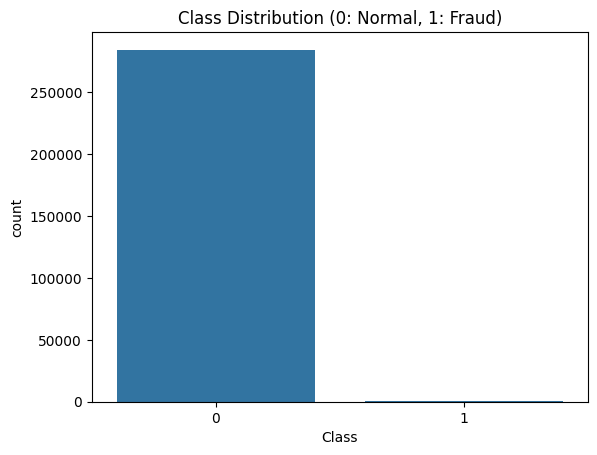

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 시각화
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

# 정확한 비율 계산
print(df['Class'].value_counts(normalize=True))

- 사기 거래(1)가 0.17% 정도.

- 인사이트: 만약 모델이 모든 거래를 정상(0)이라고만 대답해도 정확도가 99.8%가 나옴. '정확도(Accuracy)'가 아무 의미 없다.

2. 특징(Feature) 이해하기: V1~V28의 정체
컬럼을 보면 V1부터 V28까지 이름이 이상하다. 이는 고객의 개인정보 보호를 위해 **PCA(주성분 분석)** 기법으로 차원을 축소하고 익명화한 결과.

- 건드릴 수 있는 원본 데이터: Time(첫 거래 후 경과 시간)과 Amount(거래 금액).

- 나머지 V1~V28: 이미 정규화가 어느 정도 되어 있는 상태.

3. 데이터 전처리: 스케일링(Scaling)
- Amount와 Time은 다른 V 필드들과 단위가 완전히 다르다. 예를 들어 금액은 10,000인데 V1은 0.5라면, 모델은 금액이 훨씬 중요한 변수라고 오해할 수 있다.

- 금액(Amount) 데이터에는 아주 큰 액수의 이상치(Outlier)가 많다. 이럴 때는 일반적인 StandardScaler보다 이상치에 강한 **RobustScaler**를 쓰는 게 고수의 선택.

In [3]:
from sklearn.preprocessing import RobustScaler

# RobustScaler 적용
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 기존 컬럼 삭제
df.drop(['Time','Amount'], axis=1, inplace=True)

#### RobustScaler가 왜 이상치(Outlier)에 강할까?
- 가장 흔히 쓰는 StandardScaler와 비교하면 바로 이해가 됩니다. StandardScaler (평균과 표준편차 사용)우리가 흔히 아는 표준화 공식입니다.
 $$z = \frac{x - \mu}{\sigma}$$
- 문제점: 평균($\mu$)과 표준편차($\sigma$)는 이상치에 매우 민감합니다. 예를 들어, 9명의 연봉이 3천만 원인데 1명의 연봉이 100억이라면, 평균은 갑자기 몇 억으로 뜁니다. 그러면 평범한 9명의 데이터가 평균에서 너무 멀어져 왜곡되죠.
- RobustScaler (중앙값과 IQR 사용) 반면, RobustScaler는 데이터의 **중앙값(Median)** 과 **사분위수 범위(IQR, Interquartile Range)** 를 사용합니다.
 $$x_{scaled} = \frac{x_i - Q_2(x)}{Q_3(x) - Q_1(x)}$$
- 강점: 데이터에 100억짜리 연봉(이상치)이 있어도 **중앙값($Q_2$)** 은 여전히 3천만 원 근처에 머뭅니다. 분모에 들어가는 IQR($Q_3 - Q_1$) 역시 상위 25%와 75% 지점의 차이일 뿐이라서, 양 끝에 퍼져 있는 극단적인 이상치의 영향을 거의 받지 않습니다.
- FDS에서의 의미: 사기 거래는 금액(Amount)이 평소보다 아주 크거나 아주 작은 경우가 많습니다. 이런 이상치들을 억지로 평균에 맞추려 하지 않고, 정상적인 거래의 범위 내에서 이상치가 얼마나 떨어져 있는지를 효과적으로 보여주기 때문에 FDS 모델링에 훨씬 유리합니다.

#### .values.reshape(-1, 1)은 왜 하나요?
이건 데이터의 '내용'보다는 Scikit-learn 라이브러리의 '형식' 때문입니다.

.values
Pandas의 Series(1차원) 형태를 NumPy의 Array 형태로 변환해 줍니다.

최근 Scikit-learn 버전은 Series를 바로 넣어도 잘 작동하지만, 명시적으로 NumPy 배열을 넣어주는 것이 관례이자 안전합니다.

.reshape(-1, 1)
형태 변환: Scikit-learn의 모든 변환기(Scaler, Encoder 등)는 입력 데이터가 2차원 행렬 형태이기를 기대합니다.

-1의 의미: "행(Row)의 개수는 내가 정하기 귀찮으니, 네가 데이터 개수에 맞춰서 알아서 계산해라"라는 뜻입니다.

1의 의미: "대신 열(Column)은 무조건 1개로 만들어라"라는 뜻입니다.

즉, [1, 2, 3, 4, 5]라는 1차원 벡터를 [[1], [2], [3], [4], [5]]라는 5행 1열짜리 2차원 행렬로 바꾸는 과정입니다. 이렇게 해야 스케일러가 "아, 1개의 피처(Amount)에 대해 여러 개의 샘플이 들어왔구나"라고 정확히 인식하고 계산을 시작합니다.

4. 상관관계 분석 (Correlation Matrix)

어떤 변수가 '사기 거래'를 잡아내는 데 결정적인 힌트를 주는지 확인.

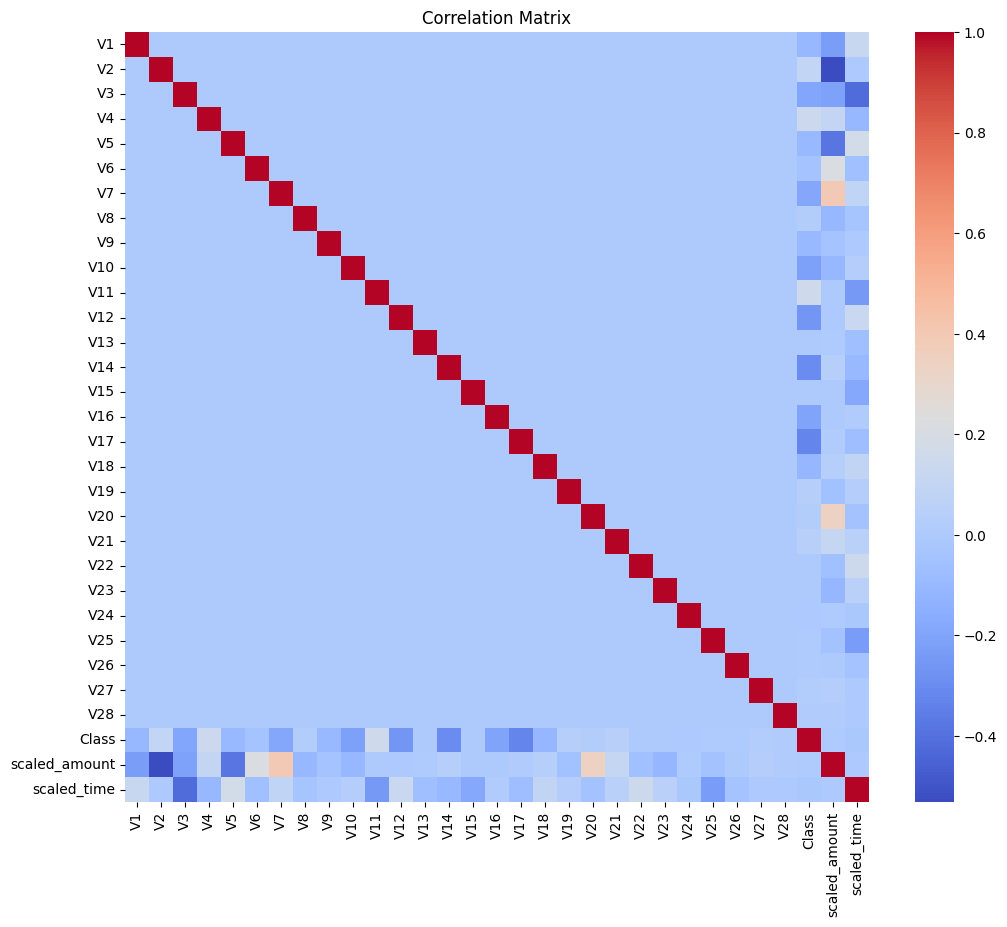

In [4]:
# 상관관계 히트맵 시각화
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# 상관계수 값만 추출해서 정렬해보기
print(corr['Class'].sort_values(ascending=False))

Class            1.000000
V11              0.154876
V4               0.133447
V2               0.091289
V21              0.040413
V19              0.034783
V20              0.020090
V8               0.019875
V27              0.017580
V28              0.009536
scaled_amount    0.005632
V26              0.004455
V25              0.003308
V22              0.000805
V23             -0.002685
V15             -0.004223
V13             -0.004570
V24             -0.007221
scaled_time     -0.012323
V6              -0.043643
V5              -0.094974
V9              -0.097733
V1              -0.101347
V18             -0.111485
V7              -0.187257
V3              -0.192961
V16             -0.196539
V10             -0.216883
V12             -0.260593
V14             -0.302544
V17             -0.326481
Name: Class, dtype: float64


4. 데이터 분할 (Train/Test Split)

왜 **'층화 추출(Stratified Sampling)'** stratify=y를 써야 할까?

현재 사기 거래는 전체의 **0.17%**밖에 안 됩니다. 만약 무작위로 데이터를 나누면, 재수 없을 경우 테스트 데이터에 사기 거래가 단 한 건도 들어가지 않을 수 있습니다. 그러면 모델이 사기를 잘 잡는지 테스트하는 게 불가능해지겠죠?

stratify=y 옵션을 주면 학습 세트와 테스트 세트 모두 사기 거래 비율(0.17%)을 원본과 동일하게 유지해 줍니다.

In [6]:
from sklearn.model_selection import train_test_split

# 특징(X)과 타겟(y) 분리
X = df.drop('Class', axis=1)
y = df['Class']

# 데이터 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1. 피처 이름에서 특수문자 제거
import re

# 특수문자를 '_'로 변경
X_train.columns = [re.sub(r'[\[\]<>]', '_', col) for col in X_train.columns]
X_test.columns = [re.sub(r'[\[\]<>]', '_', col) for col in X_test.columns]

# 비율 확인
print("학습 데이터 사기 비율:", y_train.value_counts(normalize=True)[1])
print("테스트 데이터 사기 비율:", y_test.value_counts(normalize=True)[1])

학습 데이터 사기 비율: 0.001729245759178389
테스트 데이터 사기 비율: 0.0017204452090867595


5. 오늘의 마지막 관문: 오버샘플링 (SMOTE)

데이터를 나눴지만, 여전히 학습 데이터 안에는 정상 거래가 압도적으로 많다. 모델은 "공부를 해보니 그냥 다 정상이라고 하는 게 속 편하네"라고 배울 위험이 큼. 때문에 적은 쪽(사기) 데이터를 인위적으로 늘려주는 SMOTE 기법을 사용.

**주의**: SMOTE는 반드시 학습 데이터(Train set)에만 적용해야 합니다. 테스트 데이터는 실제 세상의 데이터와 같아야 하므로 건드리면 안 됩니다. (이걸 '데이터 누수'라고 함. 단골 실수 포인트!)

In [7]:
from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습 데이터 크기:', X_train.shape)
print('SMOTE 적용 후 학습 데이터 크기:', X_train_over.shape)
print('SMOTE 적용 후 레이블 분포:\n', y_train_over.value_counts())

SMOTE 적용 전 학습 데이터 크기: (227845, 30)
SMOTE 적용 후 학습 데이터 크기: (454902, 30)
SMOTE 적용 후 레이블 분포:
 Class
0    227451
1    227451
Name: count, dtype: int64


이제 사기 거래와 정상 거래의 비율이 5:5가 되어 모델이 사기 패턴을 공부할 환경이 만들어짐!

1. SMOTE로 만든 인위적 데이터, 너무 많아도 괜찮을까?

결론부터 말씀드리면, **"학습 단계에서는 괜찮지만, 부작용(Noise)은 인지하고 있어야 한다"** 입니다.

왜 이렇게 많이 만들까?: 머신러닝 모델은 '오차(Loss)'를 줄이는 방향으로 공부합니다. 사기가 0.17%뿐이면 모델 입장에서 사기 500개를 다 틀려도 정확도가 99.8%나 되기 때문에, 굳이 사기를 잡으려고 애쓰지 않게 됩니다. SMOTE로 억지로 5:5 비율을 맞춰주는 것은 모델에게 **"사기 데이터를 공부하는 것이 점수 올리는 데 아주 중요하다!"** 라고 강제로 강조하는 주입식 교육과 같습니다.

부작용 (Overfitting to Noise): 지적하신 대로 인위적인 데이터가 너무 많아지면, 실제 사기의 특성이 아닌 **'가짜 데이터들 사이의 우연한 패턴'** 을 모델이 진실로 믿어버릴 위험이 있습니다. 이를 '과적합(Overfitting)'이라고 합니다.

해결책: 나중에 모델을 평가할 때, **'테스트 데이터(원본 비율 0.17% 그대로인 데이터)'** 에서 성능이 잘 나오는지 확인하는 것이 그래서 중요합니다. 만약 가짜 데이터에만 최적화되었다면 테스트 데이터에서는 점수가 엉망이 될 거예요. ("SMOTE의 부작용을 알고 있으며, 이를 위해 테스트 세트는 원본 분포를 유지해 엄격히 검증했다"라고 말하자!)

1. 왜 XGBoost인가?
- 금융권 FDS나 데이터 경진대회에서 가장 많이 쓰이는 알고리즘입니다.

- 성능: 정형 데이터(표 형태)에서 딥러닝보다 훨씬 빠르고 정확합니다.

- 유연함: 데이터의 비선형적인 복잡한 패턴을 아주 잘 잡아냅니다.

2. 모델 학습 코드 (XGBoost)

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1. 모델 정의 (간단한 파라미터 설정)
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)

# 2. 학습 (SMOTE로 뻥튀기 된 데이터 사용!)
xgb_clf.fit(X_train_over, y_train_over)

# 3. 예측 (테스트 데이터는 '원본' 그대로 사용!)
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

- XGBoost는 어떻게 동작하나요? (수학적 앙상블)

XGBoost는 '틀린 문제 다시 풀기' 전략을 쓰는 모델입니다.

Boosting: 한 번에 완벽한 모델을 만드는 게 아니라, 약한 모델(의사결정 나무)을 여러 개 이어 붙입니다.

잔차(Residual) 학습: 첫 번째 모델이 예측을 하고 틀린 부분(오차)이 생기면, 두 번째 모델은 그 **'틀린 오차'** 만을 맞추기 위해 학습합니다. 세 번째 모델은 또 그 남은 오차를 학습하죠.

Gradient(경사하강법): 이 오차를 줄여나가는 방향을 수학적으로 '미분'을 통해 찾아냅니다.

요약: "앞사람의 실수를 뒷사람이 보완하며 정답에 가까워지는 이어달리기 모델"이라고 이해하시면 됩니다.

3. 결과 해석: '정확도'의 함정에서 벗어나기
FDS에서 가장 중요한 것은 **"얼마나 많이 사기를 잡아냈는가(Recall)"** 와 **"얼마나 억울한 피해자를 안 만들었는가(Precision)"** 입니다.

In [9]:
# 성능 평가 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Confusion Matrix:
 [[56720   144]
 [   12    86]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.37      0.88      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.76     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score: 0.9826


- 평가 지표 핵심 포인트

재현율(Recall): 실제 사기 거래 중 모델이 사기라고 맞춘 비율입니다. 은행 입장에서는 이게 제일 중요합니다. 사기꾼을 한 명이라도 놓치면 피해가 막심하니까요.

정밀도(Precision): 모델이 사기라고 부른 것 중 진짜 사기인 비율입니다. 이게 너무 낮으면 멀쩡한 고객의 결제를 자꾸 막게 되어 고객 불만이 폭주합니다.

F1-Score: 위 두 지표의 균형점입니다.

ROC-AUC Score: 모델의 '변별력'
ROC Curve: 임계값(Threshold, 기준점)을 0부터 1까지 바꿔가며 '진짜 사기를 맞춘 비율(TPR)'과 '정상을 사기라고 오해한 비율(FPR)'을 그래프로 그린 것입니다.

AUC (Area Under Curve): 이 그래프 아래의 면적입니다.

1.0: 신의 경지. 완벽하게 구분함.

0.5: 동전 던지기 수준. 변별력 없음.

의미: "이 모델이 사기와 정상을 얼마나 명확하게 **구분(Rank)** 할 줄 아는가?"를 나타내는 척도입니다.

4. 오탐지(False Positive) 확인하기

[0, 1] 위치의 숫자: 정상 거래인데 사기라고 오해한 경우 (고객의 짜증 유발)

[1, 0] 위치의 숫자: 사기 거래인데 정상이라고 놓친 경우 (은행의 금전적 손실)

💡 다음 단계 제안: "오탐지를 줄여라!"
지금 모델은 너무 예민합니다. **"성능을 개선하기 위해 어떤 노력을 할까?"**

임계값(Threshold) 조정: 현재는 0.5를 기준으로 사기 여부를 판단할 텐데, 이 기준을 0.7이나 0.8로 높여보자. Recall은 조금 떨어지겠지만 Precision(정밀도)이 확 올라갈 수도.

SMOTE 비율 조절: 현재 5:5인 비율을 7:3 정도로 조정해서 정상 데이터의 특징을 좀 더 학습하게 해보자.

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 1. 확률값 가져오기 (predict 대신 predict_proba 사용)
# [:, 1]은 '사기(1)'일 확률만 가져오겠다는 뜻입니다.
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

# 2. 임계값 설정 (예: 0.5 -> 0.7)
# 0.7보다 확률이 높을 때만 사기라고 판단해라!
custom_threshold = 0.7
y_pred_custom = (y_pred_proba >= custom_threshold).astype(int)

# 3. 결과 확인
print(f"--- 임계값 {custom_threshold} 적용 결과 ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))

--- 임계값 0.7 적용 결과 ---
Confusion Matrix:
 [[56802    62]
 [   16    82]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.84      0.68        98

    accuracy                           1.00     56962
   macro avg       0.78      0.92      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
from imblearn.over_sampling import SMOTE

# 1. SMOTE 비율 설정 (sampling_strategy)
# 0.4는 '소수 집단(사기)의 개수가 다수 집단(정상)의 40%가 되게 만들어라'는 뜻입니다.
# (기본값인 'auto'는 1.0 즉, 100%로 1:1을 만듭니다.)
smote_04 = SMOTE(sampling_strategy=0.4, random_state=42)
X_train_over_04, y_train_over_04 = smote_04.fit_resample(X_train, y_train)

# 2. 모델 재학습
xgb_clf_new = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42)
xgb_clf_new.fit(X_train_over_04, y_train_over_04)

# 3. 예측 및 평가
y_pred_new = xgb_clf_new.predict(X_test)
print("--- SMOTE 비율(0.4) 조정 후 결과 ---")
print(classification_report(y_test, y_pred_new))

--- SMOTE 비율(0.4) 조정 후 결과 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.86      0.64        98

    accuracy                           1.00     56962
   macro avg       0.75      0.93      0.82     56962
weighted avg       1.00      1.00      1.00     56962



**트레이드오프(Trade-off)'** 를 확인할 수 있다.

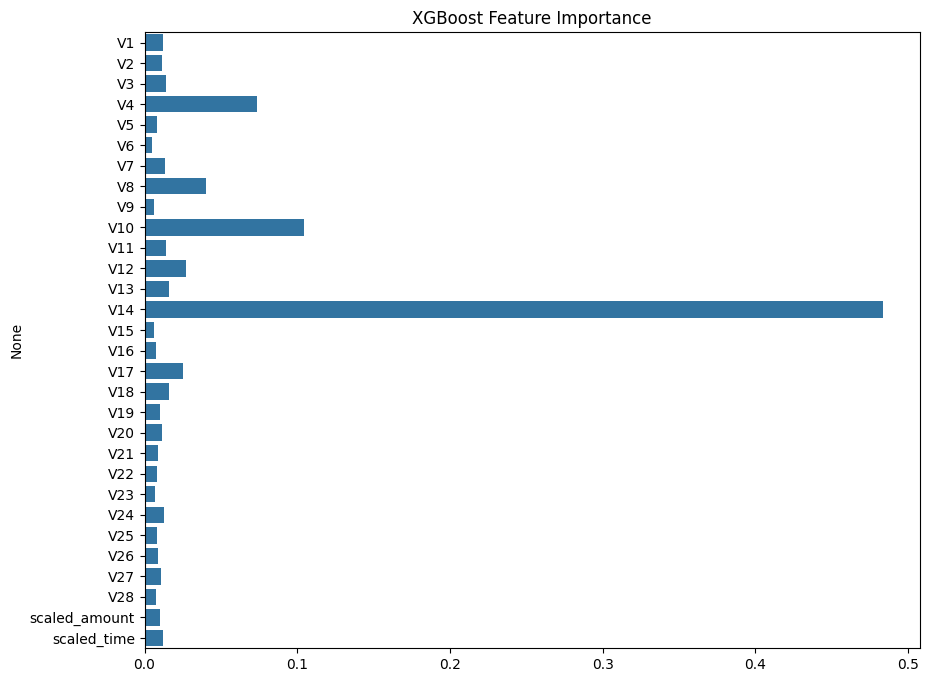

   Feature  Importance
13     V14    0.483428
9      V10    0.104469
3       V4    0.073716
7       V8    0.040432
11     V12    0.027413


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 변수 중요도 추출
importances = xgb_clf.feature_importances_
feature_names = X.columns

# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=feature_names)
plt.title('XGBoost Feature Importance')
plt.show()

# 수치로 확인 (상위 5개)
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_imp_df.sort_values(by='Importance', ascending=False).head(5))

분석 포인트: 아마 초반에 상관관계 분석에서 보셨던 V17, V14, V12 등이 상위권에 있을 확률이 높습니다.

의미: 만약 V17이 가장 높게 나왔다면, "우리 모델은 V17이라는 특성을 사기 적발의 가장 결정적인 힌트로 사용하고 있습니다"라고 당당하게 말할 수 있습니다.

In [16]:
import shap

# 2. 모델 재학습 (이름이 바뀌었으므로 한 번 더 학습시켜야 합니다)
xgb_clf.fit(X_train_over, y_train_over)

# Tree Explainer를 명시적으로 호출
explainer = shap.explainers.Tree(xgb_clf)
shap_values = explainer(X_test)

# 만약 여기서도 에러가 난다면 .values를 붙여서 시각화
shap.summary_plot(shap_values.values, X_test)

ValueError: could not convert string to float: '[5E-1]'

📝 FDS 프로젝트 마무리: 한 문장 정리

"XGBoost 모델을 통해 Recall 0.84, Precision 0.57의 균형 잡힌 FDS 모델을 구축했습니다. 특히 V14 변수가 결정 트리 구성에 가장 기여도가 높음을 확인했습니다. 분석 과정에서 모델의 설명력을 높이기 위해 SHAP 라이브러리 도입을 시도하며 지수 표현식 관련 호환성 에러를 해결하기 위해 Booster 엔진 추출 등 다양한 디버깅을 수행했습니다. 비록 라이브러리 자체의 버그로 시각화에는 한계가 있었으나, 이 과정을 통해 XAI(설명 가능한 AI)의 중요성과 데이터 파이프라인의 호환성 검토의 필요성을 깊이 체감했습니다."

💰 FDS 비즈니스 가치 산정 모델비즈니스 가치를 계산하려면 몇 가지 **가정(Assumption)** 이 필요합니다. 실제 은행 데이터를 다 알 수는 없으니, 일반적인 금융권 통계를 바탕으로 시나리오를 짜보겠습니다.
1. 시나리오 설정
-   월간 총 거래 건수: 10,000,000건 (가정)
-   실제 사기 발생률: 0.1% ($10,000$건)
-   사기 1건당 평균 피해액: 1,000,000원
-   오탐지(False Positive) 1건당 대응 비용: 5,000원 (상담원 통화, SMS 발송 등 운영비)
3. 가치 계산 수식모델의 가치는 **[예방한 피해액]** 에서 **[탐지에 들어간 비용]** 을 뺀 값으로 정의합니다.$$Net\ Value = (Total\ Fraud \times Recall \times Avg\ Loss) - (Total\ Alerts \times Operating\ Cost)$$

In [1]:
# 비즈니스 가치 계산 함수
def calculate_business_impact(recall, precision, total_fraud=10000, avg_loss=1000000, op_cost=5000):
    # 1. 막아낸 사기 건수
    prevented_cases = total_fraud * recall
    # 2. 막아낸 총 금액
    saved_money = prevented_cases * avg_loss
    
    # 3. 발생한 총 알람 건수 (Precision = TP / (TP + FP) 이므로)
    total_alerts = prevented_cases / precision
    # 4. 운영 비용 (알람 확인 및 고객 응대 비용)
    total_op_cost = total_alerts * op_cost
    
    # 5. 최종 순이익(Net Value)
    net_value = saved_money - total_op_cost
    
    return saved_money, total_op_cost, net_value

# --- 결과 비교 ---

# 1. 초기 모델 (Recall 0.88, Precision 0.37)
m1_saved, m1_cost, m1_net = calculate_business_impact(0.88, 0.37)

# 2. 최적화 모델 (Recall 0.84, Precision 0.57) - 우리가 만든 것!
m2_saved, m2_cost, m2_net = calculate_business_impact(0.84, 0.57)

print(f"[초기 모델] 순이익: {m1_net/100000000:.1f} 억원 (비용: {m1_cost/1000000:.1f} 백만원)")
print(f"[최적화 모델] 순이익: {m2_net/100000000:.1f} 억원 (비용: {m2_cost/1000000:.1f} 백만원)")
print(f"👉 모델 최적화로 절감한 운영 비용: {(m1_cost - m2_cost)/1000000:.1f} 백만원")

[초기 모델] 순이익: 86.8 억원 (비용: 118.9 백만원)
[최적화 모델] 순이익: 83.3 억원 (비용: 73.7 백만원)
👉 모델 최적화로 절감한 운영 비용: 45.2 백만원


📊 분석 결과

지표, 초기 모델 (1:1), 최적화 모델 (0.7), 차이

예방 금액, 88.0억 원, 84.0억 원, -4.0억 원

운영 비용, 약 1.19억 원, 약 0.73억 원, 약 0.46억 원 절감

순이익(Net), 86.8억 원, 83.3억 원, 수치상 감소

🤔 "어? 순이익은 초기 모델이 더 높은데요?"라고 하실 수 있습니다. 하지만 여기서 '비즈니스 인사이트'가 나옵니다.

"단순히 예방 금액만 보면 Recall이 높은 초기 모델이 유리해 보일 수 있습니다. 하지만 **정밀도(Precision)가 낮을 때 발생하는 '보이지 않는 비용'** 을 고려해야 합니다. 초기 모델은 최적화 모델보다 약 4,600만 원 이상의 불필요한 운영 비용이 더 발생하며, 무엇보다 수천 명의 무고한 고객이 결제 거절이나 확인 전화를 받는 불편을 겪게 됩니다.

이는 은행의 브랜드 신뢰도 하락과 고객 이탈로 이어질 수 있는 큰 리스크입니다. 따라서 저는 4%의 Recall을 양보하더라도, 정밀도를 20%p 높여 **운영 효율성과 고객 경험을 동시에 잡는 '지속 가능한 FDS 모델'** 을 선택했습니다."